In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 10 - Memory retention
  
This Chapter is about estimating the relationship between memory retention and time.
The model being considered is a simplified version of the exponential decay model. The model assumes that the probability that an item will be remembered after a period of time $t$ has elapsed is $\theta_{t} = \text{exp}(−\alpha t)+\beta$, with the restriction $0 < \theta_{t} < 1$. The $\alpha$ parameter corresponds to the rate of decay of information. The $\beta$ parameter corresponds to a baseline level of remembering that is assumed to remain even after very long time periods.
  
## 10.1 No individual differences


$$ \alpha \sim \text{Beta}(1,1)$$
$$ \beta \sim \text{Beta}(1,1)$$
$$ \theta_{j} = \text{min}(1,\text{exp}(−\alpha t_{j})+\beta)$$
$$ k_{ij} \sim \text{Binomial}(\theta_{j},n)$$

Applied logodds-transform to alpha and added transformed alpha_logodds to model.
Applied logodds-transform to beta and added transformed beta_logodds to model.
Assigned NUTS to alpha_logodds
Assigned NUTS to beta_logodds
Assigned Metropolis to kij_missing
Assigned Metropolis to predict
 [-----------------100%-----------------] 10000 of 10000 complete in 13.6 sec

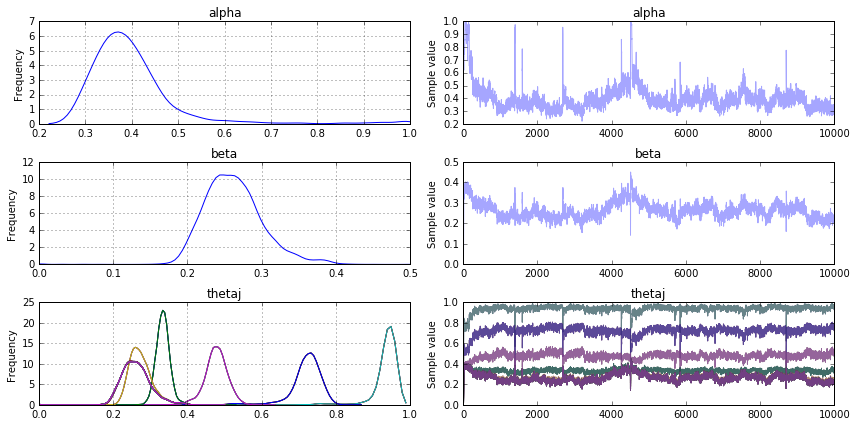

In [2]:
t     = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
nt    = len(t)
# slist = [0,1,2,3]
ns    = 4
tmat  = np.repeat(t,ns).reshape(nt,-1).T
k1 = np.ma.masked_values([18, 18, 16, 13, 9, 6, 4, 4, 4, -999,
               17, 13,  9,  6, 4, 4, 4, 4, 4, -999,
               14, 10,  6,  4, 4, 4, 4, 4, 4, -999,
               -999, -999, -999, -999, -999, -999, -999, -999, -999, -999], 
                         value=-999).reshape(ns,-1)

n = 18

with pm.Model() as model1:
    alpha = pm.Beta("alpha",alpha=1,beta=1)
    beta = pm.Beta("beta",alpha=1,beta=1)
    theta = T.exp(-alpha*tmat[:])+beta
#     kij = pm.Binomial("kij",p=theta,n=n,observed=k1[:])

    # thetaj = pm.Deterministic("thetaj",T.ones_like(theta)*T.gt(theta,1)+theta*T.lt(theta,1))
    # thetaj = pm.Deterministic("thetaj",T.minimum(theano.shared(1),theta))
    thetaj = pm.Deterministic("thetaj",theta*T.lt(theta,1))
    # thetaj = pm.Deterministic("thetaj",T.clip(theta, 0, 1))
    
    kij = pm.Binomial("kij",p=thetaj,n=n,observed=k1)
    
    ## cannot use sample_ppc for multi-dimensional response?
    predict = pm.Binomial("predict",p=thetaj,n=n,shape=(ns,nt))
    
    trace1=pm.sample(1e4, model=model1)

burnin=0    
pm.traceplot(trace1[burnin:],varnames=['alpha','beta','thetaj']);
plt.show()

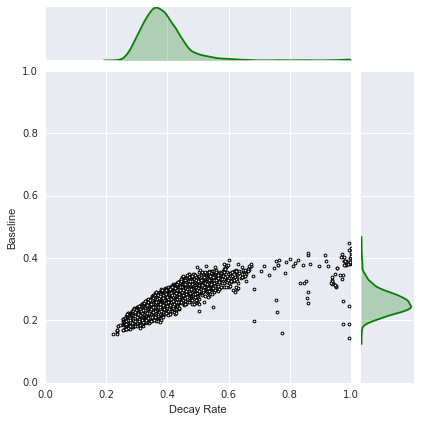

In [3]:
# reproduce Fig 10.2
import seaborn as sns

xtrace = trace1['alpha'][1000:]
ytrace = trace1['beta'][1000:]

ns1 = xtrace.shape

datmp2 = np.zeros((ns1[0], 2))
datmp2[:,0]=xtrace
datmp2[:,1]=ytrace

df2 = pd.DataFrame(datmp2,columns=["x", "y"])
# sns.jointplot(x="x", y="y", data=df);
g = sns.jointplot(x="x", y="y", data=df2, kind="kde", color="g", 
                  stat_func=None ,xlim=(0,1), ylim=(0,1))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".",)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('Decay Rate', 'Baseline')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

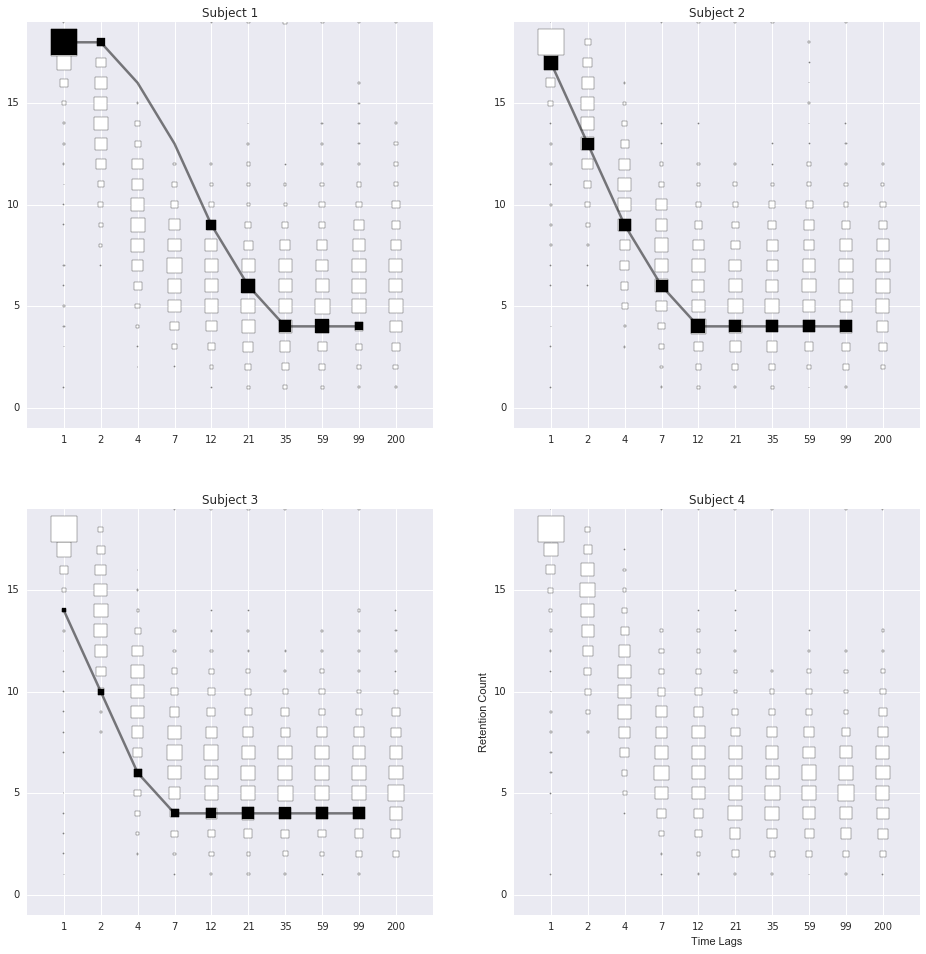

In [4]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
predictrace = trace1['predict'][:]


plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2,2)
bins = np.arange(0,n+1)
ax1=[];
for ip in np.arange(ns):
    ispredi = np.squeeze(predictrace[:,ip,:])
    ax1 = plt.subplot(gs[ip])
    for itt in np.arange(len(t)):
        y2,binEdges2=np.histogram(ispredi[:,itt],bins=bins,normed=True)
        ax1.scatter(itt*np.ones(bins.size), binEdges2+1, s=y2*1000, c='w', marker='s')
        if (k1[ip,itt] is np.ma.masked)==0:
            ax1.scatter(itt, k1[ip,itt], s=y2[k1[ip,itt]-1]*1000, c='k', marker='s')
    plt.plot(np.arange(len(t)),k1[ip,:],'k',lw=2.5,alpha=.5)
    plt.xlim(-1,10)
    plt.ylim(-1,19)
    plt.xticks(np.arange(len(t)), t)
    plt.title('Subject'+' '+str(ip+1))
plt.xlabel('Time Lags')
plt.ylabel('Retention Count')
plt.show()

## 10.2 Full individual differences


$$ \alpha_{i} \sim \text{Beta}(1,1)$$
$$ \beta_{i} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

Applied logodds-transform to alpha and added transformed alpha_logodds to model.
Applied logodds-transform to beta and added transformed beta_logodds to model.
Assigned NUTS to alpha_logodds
Assigned NUTS to beta_logodds
Assigned Metropolis to kij_missing
Assigned Metropolis to predict
 [-----------------100%-----------------] 10000 of 10000 complete in 265.3 sec

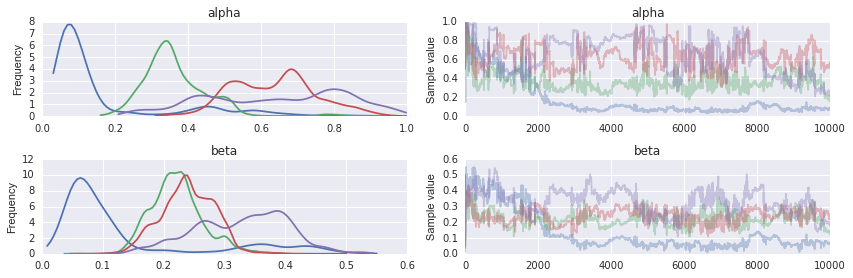

In [5]:
import theano
tshare = theano.shared(t)
cshare = theano.shared(np.ones(t.shape))

with pm.Model() as model2:
    alpha = pm.Beta("alpha",alpha=1,beta=1,shape=ns)
    beta = pm.Beta("beta",alpha=1,beta=1,shape=ns)
    theta = T.exp(-T.outer(alpha,tshare))+T.outer(beta,cshare)
#     kij = pm.Binomial("kij",p=theta,n=n,observed=k1[:])
    
    # thetaj = pm.Deterministic("thetaj",T.ones_like(theta)*T.gt(theta,1)+theta*T.lt(theta,1))
    # thetaj = pm.Deterministic("thetaj",T.minimum(1,theta))
    thetaj = pm.Deterministic("thetaj",theta*T.lt(theta,1))
    kij = pm.Binomial("kij",p=thetaj,n=n,observed=k1)
    
    predict = pm.Binomial("predict",p=thetaj,n=n,shape=(ns,nt))

    trace2=pm.sample(1e4, model=model2)

burnin=0    
pm.traceplot(trace2[burnin:],varnames=['alpha','beta']);
plt.show()

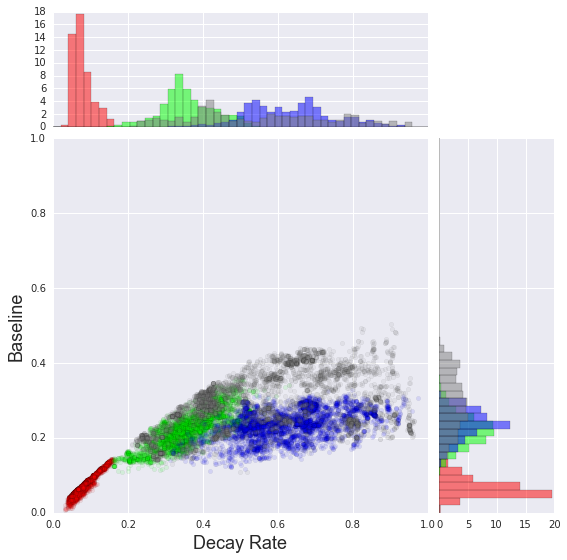

In [10]:
# reproduce Fig 10.5
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels
xtrace = trace2['alpha'][5000:]
ytrace = trace2['beta'][5000:]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# now determine limits by hand:
binwidth1 = 0.25
    
# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

cc = np.array([[1,0,0],[0,1,0],[0,0,1],[.5,.5,.5]])

for iss in np.arange(ns):
    x=xtrace[:,iss]
    y=ytrace[:,iss]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_xlim((0, 1))
    axScatter.set_ylim((0, 1))

    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y,c=cc[iss,:],alpha=.1)
    axScatter.set_xlabel('Decay Rate',fontsize=18)
    axScatter.set_ylabel('Baseline',fontsize=18)
    
    bins1 = np.linspace(0, 1, 50)
    axHistx.hist(x, bins=bins1,color=cc[iss,:],alpha=.5,normed=True)
    bins2 = np.linspace(0, 1, 50)
    axHisty.hist(y, bins=bins2, color=cc[iss,:],alpha=.5,normed=True, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
plt.show()


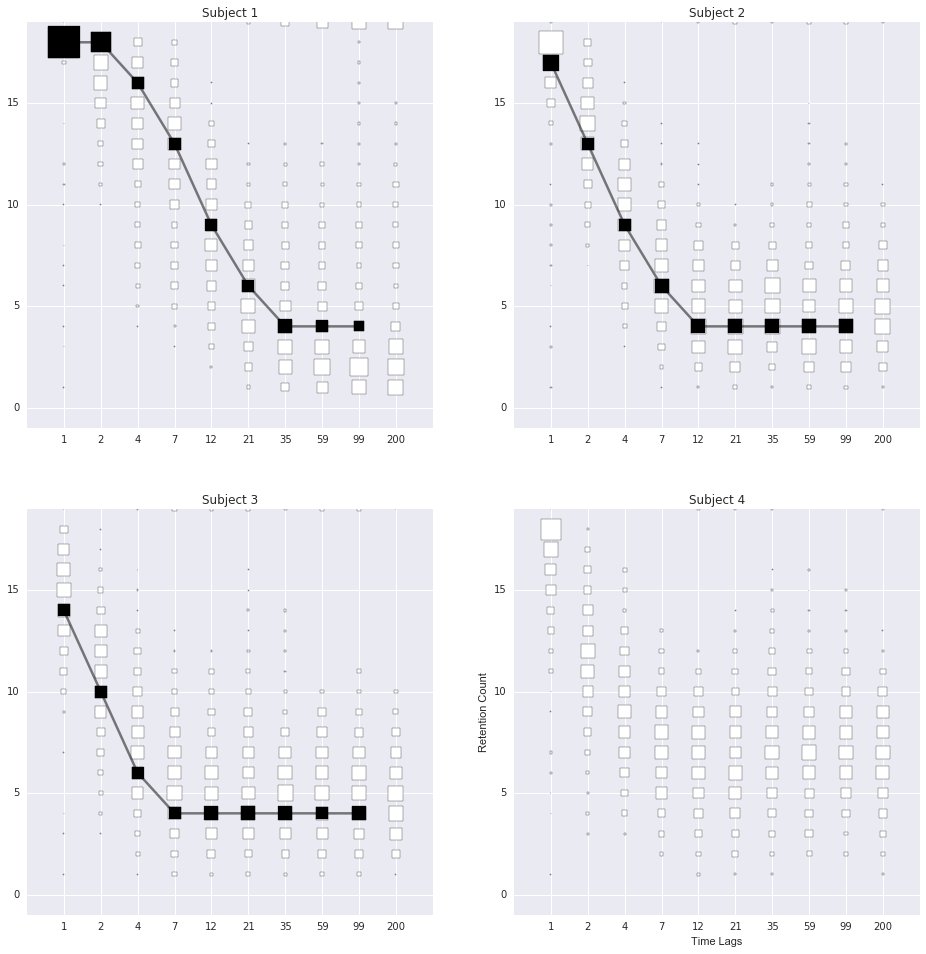

In [8]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
predictrace = trace2['predict'][:]

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2,2)
bins = np.arange(0,n+1)
ax1=[];
for ip in np.arange(ns):
    ispredi = np.squeeze(predictrace[:,ip,:])
    ax1 = plt.subplot(gs[ip])
    for itt in np.arange(len(t)):
        y2,binEdges2=np.histogram(ispredi[:,itt],bins=bins,normed=True)
        ax1.scatter(itt*np.ones(bins.size), binEdges2+1, s=y2*1000, c='w', marker='s')
        if (k1[ip,itt] is np.ma.masked)==0:
            ax1.scatter(itt, k1[ip,itt], s=y2[k1[ip,itt]-1]*1000, c='k', marker='s')
    plt.plot(np.arange(len(t)),k1[ip,:],'k',lw=2.5,alpha=.5)
    plt.xlim(-1,10)
    plt.ylim(-1,19)
    plt.xticks(np.arange(len(t)), t)
    plt.title('Subject'+' '+str(ip+1))
plt.xlabel('Time Lags')
plt.ylabel('Retention Count')
plt.show()

## 10.3 Full individual differences


$$ \mu_{\alpha} \sim \text{Beta}(1,1)$$
$$ \lambda_{\alpha} \sim \text{Gamma}(.001,.001)$$
$$ \mu_{\beta} \sim \text{Beta}(1,1)$$
$$ \lambda_{\beta} \sim \text{Gamma}(.001,.001)$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha}, \lambda_{\alpha})_{\mathcal I(0,1)} $$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta}, \lambda_{\beta})_{\mathcal I(0,1)} $$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

Applied log-transform to lambdaa and added transformed lambdaa_log to model.
Applied log-transform to lambdab and added transformed lambdab_log to model.
Applied interval-transform to mua and added transformed mua_interval to model.
Applied interval-transform to mub and added transformed mub_interval to model.
Assigned NUTS to lambdaa_log
Assigned NUTS to lambdab_log
Assigned NUTS to mua_interval
Assigned NUTS to mub_interval
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned Metropolis to kij_missing
Assigned Metropolis to predict
 [-----------------100%-----------------] 10000 of 10000 complete in 771.1 sec

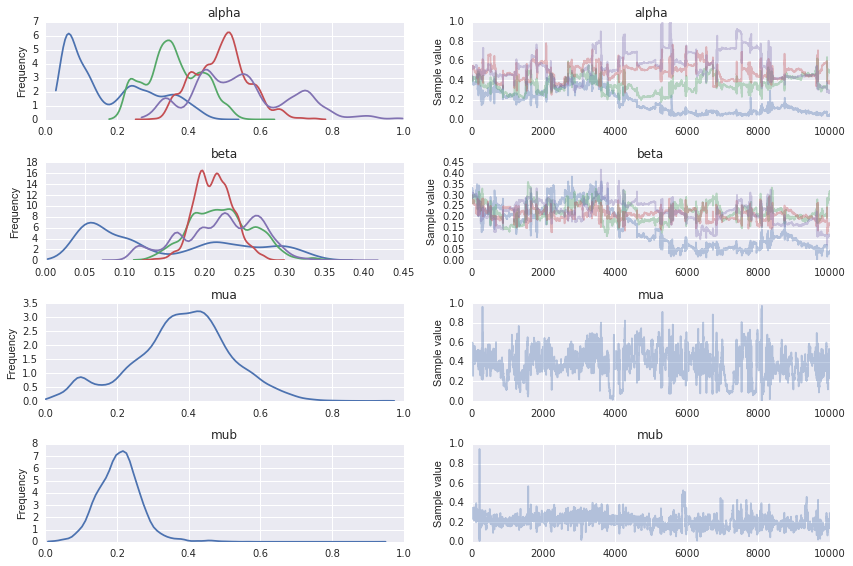

In [9]:
tshare = theano.shared(t)
cshare = theano.shared(np.ones(t.shape))

from scipy import optimize
with pm.Model() as model3:
    # mua = pm.Beta("mua",alpha=1,beta=1)
    lambdaa = pm.Gamma("lambdaa",alpha=.001,beta=.001)
    # mub = pm.Beta("mub",alpha=1,beta=1)
    lambdab = pm.Gamma("lambdab",alpha=.001,beta=.001)
    # replace Beta(1,1) with Uniform(0,1) for the prior of mu
    mua = pm.Uniform("mua",0,1,testval=.4)
    mub = pm.Uniform("mub",0,1,testval=.3)
    
    BoundedNormal = pm.Bound(pm.Normal,lower=0, upper=1)
    alpha = BoundedNormal("alpha",mu=mua,tau=lambdaa,shape=ns)
    beta = BoundedNormal("beta",mu=mub,tau=lambdab,shape=ns)
    
    theta = T.exp(-T.outer(alpha,tshare))+T.outer(beta,cshare)
#     kij = pm.Binomial("kij",p=theta,n=n,observed=k1[:])
    
    # thetaj = pm.Deterministic("thetaj",T.ones_like(theta)*T.gt(theta,1)+theta*T.lt(theta,1))
    # thetaj = pm.Deterministic("thetaj",T.minimum(1,theta))
    thetaj = pm.Deterministic("thetaj",theta*T.lt(theta,1))
    kij = pm.Binomial("kij",p=thetaj,n=n,observed=k1)
    
    predict = pm.Binomial("predict",p=thetaj,n=n,shape=(ns,nt))
    
    trace3=pm.sample(1e4, model=model3)
    
burnin=0
pm.traceplot(trace3[burnin:],varnames=['alpha','beta','mua','mub'])
plt.show()

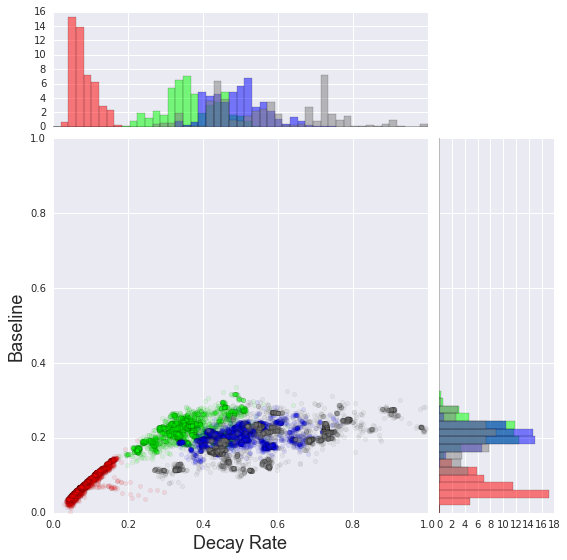

In [11]:
# reproduce Fig 10.8
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels
xtrace = trace3['alpha'][5000:]
ytrace = trace3['beta'][5000:]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# now determine limits by hand:
binwidth1 = 0.25
    
# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

cc = np.array([[1,0,0],[0,1,0],[0,0,1],[.5,.5,.5]])

for iss in np.arange(ns):
    x=xtrace[:,iss]
    y=ytrace[:,iss]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_xlim((0, 1))
    axScatter.set_ylim((0, 1))

    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y,c=cc[iss,:],alpha=.1)
    axScatter.set_xlabel('Decay Rate',fontsize=18)
    axScatter.set_ylabel('Baseline',fontsize=18)
    
    bins1 = np.linspace(0, 1, 50)
    axHistx.hist(x, bins=bins1,color=cc[iss,:],alpha=.5,normed=True)
    bins2 = np.linspace(0, 1, 50)
    axHisty.hist(y, bins=bins2, color=cc[iss,:],alpha=.5,normed=True, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
plt.show()


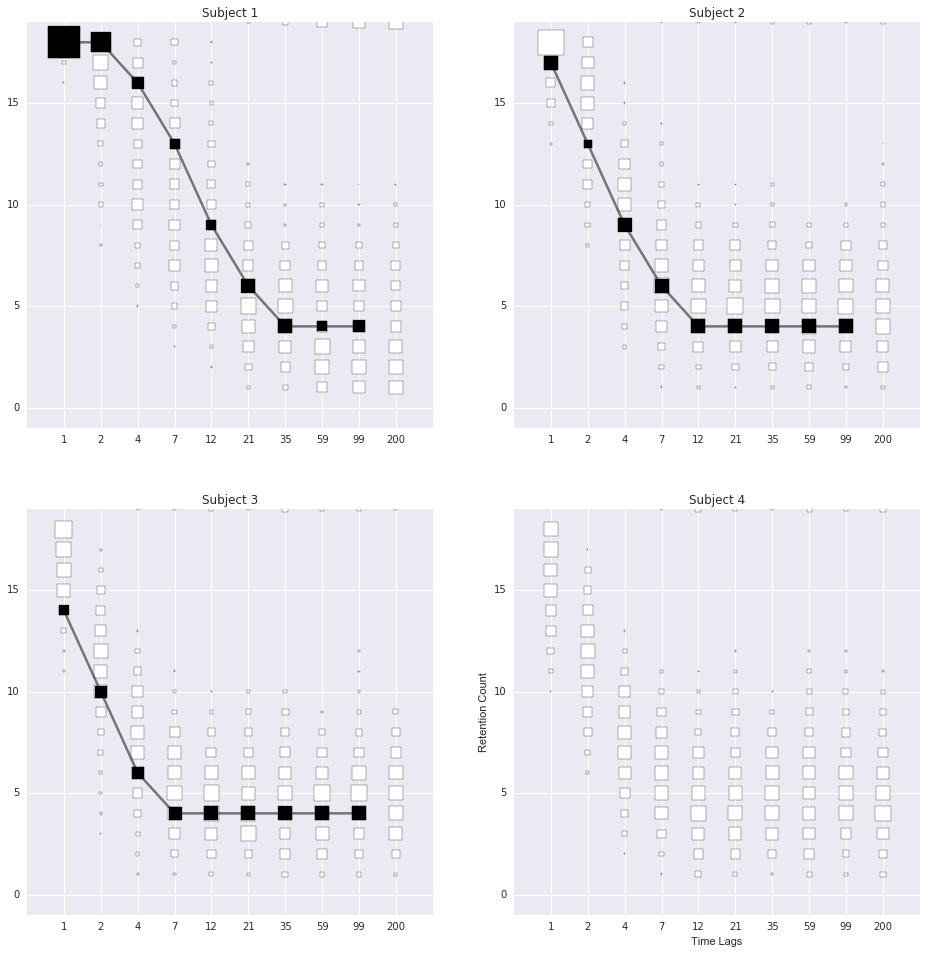

In [12]:
# reproduce Fig 10.9
# The posterior predictive distribution for the model that assumes no individual
# differences.
predictrace = trace3['predict'][:]

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2,2)
bins = np.arange(0,n+1)
ax1=[];
for ip in np.arange(ns):
    ispredi = np.squeeze(predictrace[:,ip,:])
    ax1 = plt.subplot(gs[ip])
    for itt in np.arange(len(t)):
        y2,binEdges2=np.histogram(ispredi[:,itt],bins=bins,normed=True)
        ax1.scatter(itt*np.ones(bins.size), binEdges2+1, s=y2*1000, c='w', marker='s')
        if (k1[ip,itt] is np.ma.masked)==0:
            ax1.scatter(itt, k1[ip,itt], s=y2[k1[ip,itt]-1]*1000, c='k', marker='s')
    plt.plot(np.arange(len(t)),k1[ip,:],'k',lw=2.5,alpha=.5)
    plt.xlim(-1,10)
    plt.ylim(-1,19)
    plt.xticks(np.arange(len(t)), t)
    plt.title('Subject'+' '+str(ip+1))
plt.xlabel('Time Lags')
plt.ylabel('Retention Count')
plt.show()
